# ABR analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from usnm2p.fileops import get_data_root, save_figs_book
from usnm2p.logger import logger
from usnm2p.postpro import free_expand
from usnm2p.abr_utils import *
from usnm2p.constants import *
from usnm2p.plotters import harmonize_axes_limits

figs = {}

### Input/output directories

In [3]:
dataroot = get_data_root(kind='ABR')
figsroot = get_data_root(kind=DataRoot.FIG)

### Parameters

In [4]:
ABR_tbounds = (0.19, 0.26)  # bounds of ABR response window (s)

### Load input data

In [5]:
# List input data files
datadir = os.path.join(dataroot, 'SST130')
ABF_files = [f for f in os.listdir(datadir) if f.endswith('.abf')]
ABF_fpaths = {os.path.splitext(f)[0]: os.path.join(datadir, f) for f in ABF_files}
logger.info(f'found {len(ABF_files)} ABF files in {datadir}')

# Load ABR data
data = pd.concat({k: load_abr_data(v) for k, v in ABF_fpaths.items()}, axis=0, names=['dataset'])

# Select ABR window subset
data = data.loc[(data[Label.TIME] >= ABR_tbounds[0]) & (data[Label.TIME] <= ABR_tbounds[1])]

# Extract sampling rate
dt = data[Label.TIME].iloc[:2].diff().iloc[-1]  # s
sr = np.round(1 / dt)  # Hz
logger.info(f'sampling rate: {sr} Hz')

# Extract information from 'dataset' index
logger.info('extracting information from "dataset" index')
datasets = data.index.unique('dataset')
info = parse_ABR_parameters(datasets)

# Extract stimulus frequencies directly from stimulus waveforms
logger.info('extracting stimulus frequencies directly from stimulus waveforms')
stimfreqs = (data['stim (mV)']
    .groupby('dataset', group_keys=[datasets])
    .agg(lambda x: extract_stim_frequency(x, dt))
    .apply(lambda x: np.round(x * 1e-3))
    .rename('freq (kHz)')
    .loc[datasets]
)

# Check that extracted stimulus frequencies match those in 'info'
mismatchs = stimfreqs[stimfreqs != info['freq (kHz)']].index.values
if len(mismatchs) > 0:
    mismatchs = pd.concat([info.loc[mismatchs], stimfreqs.loc[mismatchs]], axis=1)
    raise ValueError(f'stimulus frequencies mismatch between file name and waveform data in the following datasets:\n{mismatchs}')

# Add 'info' columns to data index
exp_info = free_expand(info, data)
data = pd.concat([data, exp_info], axis=1)
for k in info.columns:
    logger.info(f'adding {k} information to data index')
    data = data.set_index(k, append=True)
data = data.reorder_levels(['dataset', *info.columns, 'sweep', 'sample'])

# Show data
data

 2024/08/22 18:49:11: found 11 ABF files in /Users/tlemaire/Documents/data/usnm/ABR/SST130
 2024/08/22 18:49:11: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/postdeafening_leftear_8kHz_90dB_20316006.abf ABF file
 2024/08/22 18:49:11: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/postdeafening_rightear_4kHz_90dB_20316003.abf ABF file
 2024/08/22 18:49:12: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/predeafening_rightear_4kHz_90dB_20304007.abf ABF file
 2024/08/22 18:49:12: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/predeafening_xear_4kHz_xdB_20304009.abf ABF file
 2024/08/22 18:49:12: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/predeafening_xear_4kHz_xdB_20304008.abf ABF file
 2024/08/22 18:49:12: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/predeafening_leftear_4kHz_90dB_20304003.abf ABF file
 2024/08/22 18:49:12: loading /Users/tlemaire/Documents/data/usnm/ABR/SST130/predeafening_xear_4kHz_xdB_20304006.abf ABF file
 2024/0

time (s)  \
dataset                                  condition ear  freq (kHz) level (dB) acq      sweep sample             
postdeafening_leftear_8kHz_90dB_20316006 post      left 8          90.0       20316006 0     3800     0.19000   
                                                                                             3801     0.19005   
                                                                                             3802     0.19010   
                                                                                             3803     0.19015   
                                                                                             3804     0.19020   
...                                                                                                       ...   
postdeafening_leftear_4kHz_90dB_20316005 post      left 4          90.0       20316005 511   5196     0.25980   
                                                                                             5197     0.25985   
                                                                                             5198     0.25990   
                                                                                             5199     0.25995   
                                                                                             5200     0.26000   

                                                                                                     stim (mV)  \
dataset                                  condition ear  freq (kHz) level (dB) acq      sweep sample              
postdeafening_leftear_8kHz_90dB_20316006 post      left 8          90.0       20316006 0     3800    12.817383   
                                                                                             3801    14.953613   
                                                                                             3802    13.732910   
                                                                                             3803    13.122559   
                                                                                             3804    12.512207   
...                                                                                                        ...   
postdeafening_leftear_4kHz_90dB_20316005 post      left 4          90.0       20316005 511   5196    12.817383   
                                                                                             5197    11.596680   
                                                                                             5198    10.986328   
                                                                                             5199    10.375977   
                                                                                             5200    16.784668   

                                                                                                      ABR (mV)  
dataset                                  condition ear  freq (kHz) level (dB) acq      sweep sample             
postdeafening_leftear_8kHz_90dB_20316006 post      left 8          90.0       20316006 0     3800    10.070801  
                                                                                             3801     3.662109  
                                                                                             3802    -1.525879  
                                                                                             3803     1.831055  
                                                                                             3804     6.713867  
...                                                                                                        ...  
postdeafening_leftear_4kHz_90dB_20316005 post      left 4          90.0       20316005 511   5196     3.967285  
                                                                                             5197     2.441406  
                  

### Extract stimulus time bounds from the stimulus channel and align 0 to stimulus onset 

In [6]:
# Extract stimulus ON-OFF indexes from stimulus waveforms
logger.info('extracting stimulus ON-OFF indexes from stimulus waveforms')
stim_ibounds = data['stim (mV)'].groupby('dataset').agg(extract_stim_window)

# Convert to time bounds using reference 'time' vectors
logger.info('converting stimulus ON-OFF indexes to time bounds')
stim_tbounds = pd.Series(
    {k: tuple(data.loc[k, Label.TIME].iloc[np.array(ib)]) for k, ib in stim_ibounds.items()},
    name='stim bounds (s)')

# Offset time vectors to align stimulus onset with t=0
logger.info('offsetting time vectors to align stimulus onset with t=0')
data[Label.TIME] = (
    data[Label.TIME]
    .groupby('dataset')
    .transform(lambda x: x - stim_tbounds[x.index[0][0]][0])
)

# Offset stimulus time bounds as well
logger.info('offsetting stimulus time bounds')
stim_tbounds = pd.Series(
    {k: tuple([0, v[1] - v[0]]) for k, v in stim_tbounds.items()},
    name=stim_tbounds.name)

 2024/08/22 18:49:56: extracting stimulus ON-OFF indexes from stimulus waveforms
 2024/08/22 18:49:58: converting stimulus ON-OFF indexes to time bounds


/var/folders/86/b3z067_j0sbfgbhl7gx4p5640000gn/T/ipykernel_5038/453751699.py:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  {k: tuple(data.loc[k, Label.TIME].iloc[np.array(ib)]) for k, ib in stim_ibounds.items()},


 2024/08/22 18:49:59: offsetting time vectors to align stimulus onset with t=0
 2024/08/22 18:50:02: offsetting stimulus time bounds


### Plot ABR responses

 2024/08/22 18:50:02: plotting representative stimulus waveform
 2024/08/22 18:50:02: adding inset in the middle of the stimulus waveform
 2024/08/22 18:50:03: plotting ABR waveform for "postdeafening_leftear_4kHz_90dB_20316005" dataset
 2024/08/22 18:50:05: plotting ABR waveform for "postdeafening_leftear_8kHz_90dB_20316006" dataset
 2024/08/22 18:50:06: plotting ABR waveform for "postdeafening_rightear_4kHz_90dB_20316003" dataset
 2024/08/22 18:50:08: plotting ABR waveform for "postdeafening_rightear_8kHz_90dB_20316004" dataset
 2024/08/22 18:50:09: plotting ABR waveform for "predeafening_leftear_4kHz_90dB_20304003" dataset
 2024/08/22 18:50:10: plotting ABR waveform for "predeafening_rightear_4kHz_90dB_20304007" dataset
 2024/08/22 18:50:12: plotting ABR waveform for "predeafening_xear_4kHz_xdB_20304004" dataset
 2024/08/22 18:50:13: plotting ABR waveform for "predeafening_xear_4kHz_xdB_20304005" dataset
 2024/08/22 18:50:15: plotting ABR waveform for "predeafening_xear_4kHz_xdB_203

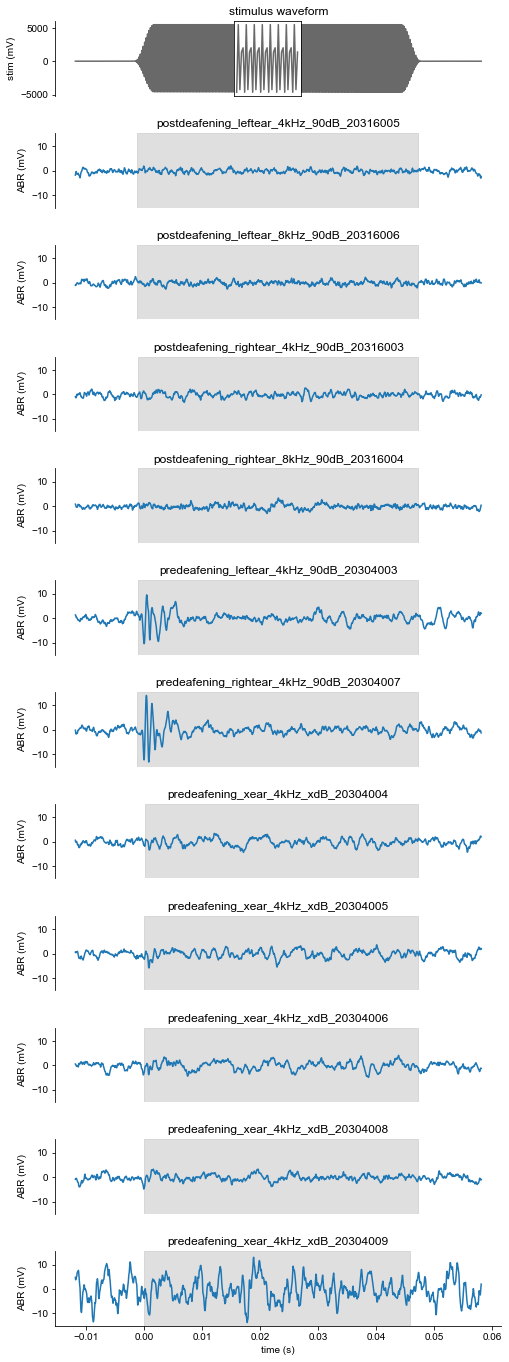

In [7]:
# Create figure
naxes = len(data.index.unique('dataset')) + 1
fig, axes = plt.subplots(naxes, 1, figsize=(8, 2 * naxes))
sns.despine(fig=fig)

# Plot representative stimulus waveform (from first sweep) on first axis
sweepdata = data.loc[tuple(list(data.index[0][:-1]) + [slice(None)])]
logger.info('plotting representative stimulus waveform')
axes[0].set_title('stimulus waveform')
sns.lineplot(
    ax=axes[0], 
    data=sweepdata,
    x=Label.TIME,
    y='stim (mV)',
    c='dimgrey',
)

# Add inset in the middle of the stimulus waveform
logger.info('adding inset in the middle of the stimulus waveform')
inset_tbounds = np.linspace(*stim_tbounds.iloc[0], 100)[[48, 52]]
inset_data = sweepdata[sweepdata[Label.TIME].between(*inset_tbounds)]
inset_ax = axes[0].inset_axes([0.4, 0, 0.15, 1])
inset_ax.set_xticks([])
inset_ax.set_yticks([])
sns.lineplot(
    ax=inset_ax,
    data=inset_data,
    x=Label.TIME,
    y='stim (mV)',
    c='dimgrey',
)

# Plot ABR waveforms on subsequent axes
for ax, (dataset, gdata) in zip(axes[1:], data.groupby('dataset')):
    logger.info(f'plotting ABR waveform for "{dataset}" dataset')
    ax.set_title(dataset)
    sns.lineplot(
        ax=ax,
        data=gdata,
        x=Label.TIME,
        y='ABR (mV)',
        errorbar=None,
    )
    ax.axvspan(*stim_tbounds[dataset], color='silver', alpha=0.5)

# Adjust layout
harmonize_axes_limits(axes[1:], 'y')
fig.subplots_adjust(hspace=0.5)
for ax in axes[:-1]:
    sns.despine(ax=ax, bottom=True)
    ax.set_xticks([])
    ax.set_xlabel(None)

# Add figure to dictionary
figs['all ABRs'] = fig

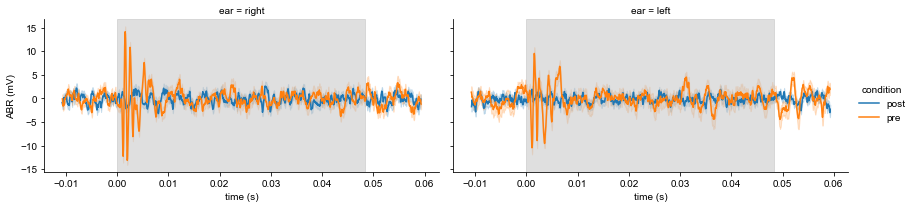

In [8]:
# Select only data at 4 kHz and with clear dB and ear information
subdata = data.loc[data.index.get_level_values('level (dB)') == 90]
subdata = subdata.loc[subdata.index.get_level_values('ear') != 'x']
subdata = subdata.loc[subdata.index.get_level_values('freq (kHz)') == 4]

# Plot ABR waveforms for each ear, frequency and condition
g = sns.relplot(
    kind='line',
    data=subdata,
    x=Label.TIME,
    y='ABR (mV)',
    col='ear',
    hue='condition',
    errorbar='se',
    aspect=2,
    height=3,
)
for ax in g.axes.flat:
    ax.axvspan(*stim_tbounds[subdata.index.unique('dataset')[0]], color='silver', alpha=0.5)

# Add figure to dictionary
figs['direct comp ABRs'] = g.fig

### Save figure(s) and log completion

In [10]:
save_figs_book(figsroot, figs, suffix='ABRs')
logger.info('done')

 2024/08/22 18:51:15: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2024.08.22/figs_ABRs.pdf:


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


 2024/08/22 18:51:16: done
